In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load data
df = pd.read_csv('1000851.csv')

# Data Preprocessing & Feature Engineering

In [3]:
# Convert start_date or ball into useful formats if needed
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

In [4]:
# Target variable: Wicket? 1 if wicket, else 0
df['wicket'] = df['wicket_type'].notnull().astype(int)

In [5]:
# Drop columns not useful or too granular for prediction
df = df.drop(columns=['player_dismissed', 'other_wicket_type', 'other_player_dismissed', 'penalty'])

In [6]:
# Fill missing values for extras columns (if any)
extras_cols = ['extras', 'wides', 'noballs', 'byes', 'legbyes']
for col in extras_cols:
    df[col] = df[col].fillna(0)

In [7]:
# Extract innings and ball number for numeric features
df['ball_over'] = df['ball'].apply(lambda x: float(str(x)))

In [8]:
# Encode categorical variables: batting_team, bowling_team, striker, non_striker, bowler, venue
cat_cols = ['batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler', 'venue', 'season']
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [9]:
# Select relevant features for modeling
features = ['innings', 'ball_over', 'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
            'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'season', 'venue']

X = df[features]
y = df['wicket']

In [10]:
# Train-test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# Feature Scaling (important for Neural Network)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Exploratory Data Analysis (EDA)

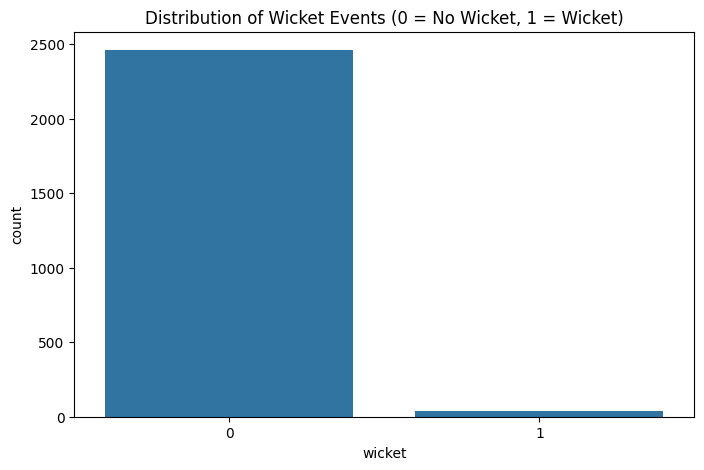

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x='wicket', data=df)
plt.title('Distribution of Wicket Events (0 = No Wicket, 1 = Wicket)')
plt.show()

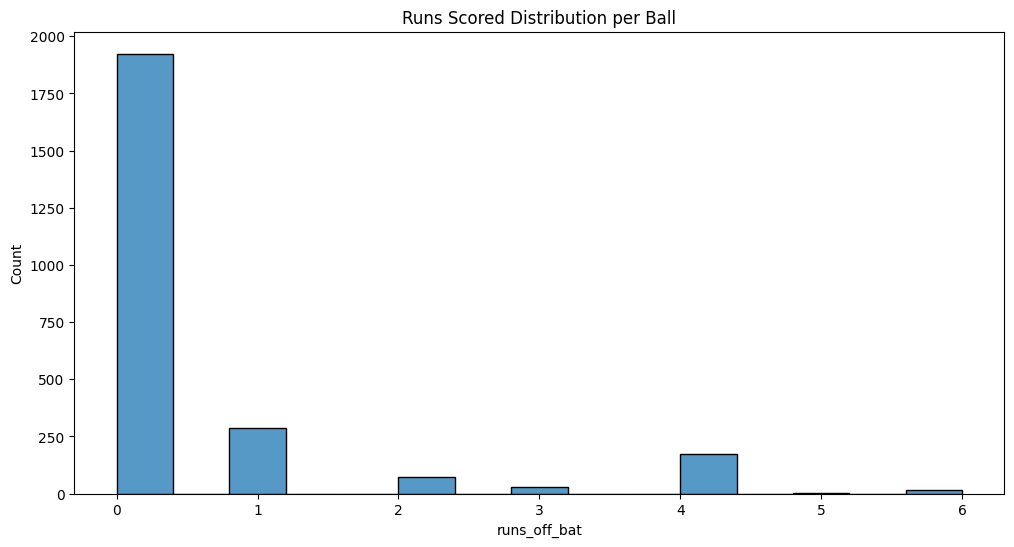

In [13]:
plt.figure(figsize=(12,6))
sns.histplot(df['runs_off_bat'], bins=15, kde=False)
plt.title('Runs Scored Distribution per Ball')
plt.show()

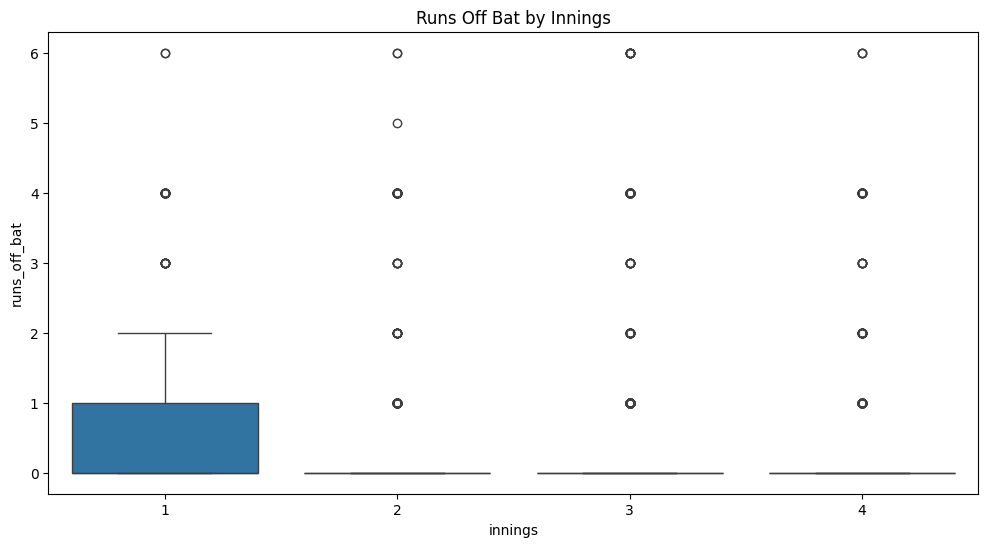

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x='innings', y='runs_off_bat', data=df)
plt.title('Runs Off Bat by Innings')
plt.show()

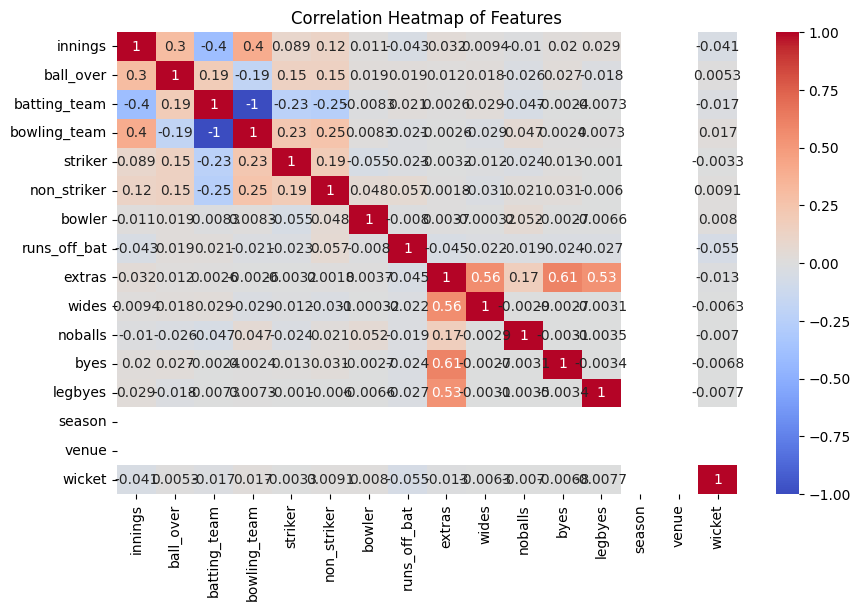

In [15]:
plt.figure(figsize=(10,6))
sns.heatmap(df[features + ['wicket']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Features')
plt.show()

# Modeling and Evaluation

In [16]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.predict(X_test).ravel()
    
    print(f"----- {model_name} Classification Report -----")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

----- Random Forest Classification Report -----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       492
           1       0.00      0.00      0.00         8

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.49       500
weighted avg       0.97      0.98      0.97       500



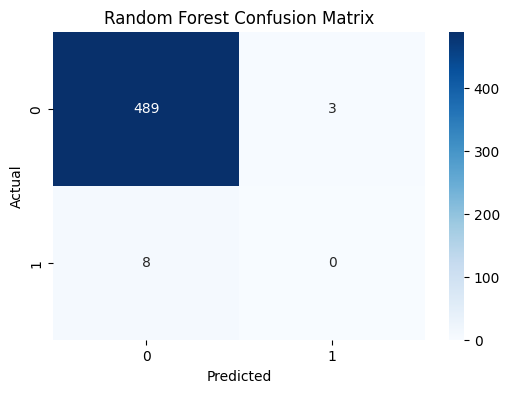

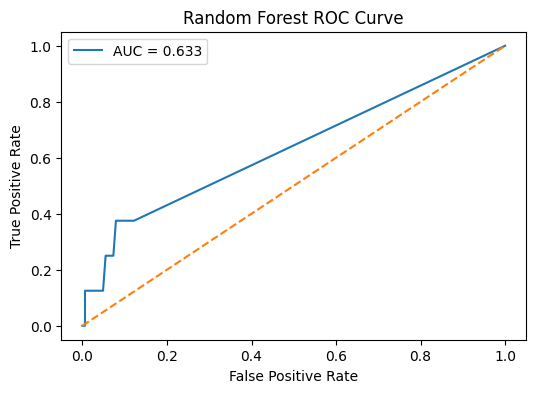

In [17]:
# 1. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test, "Random Forest")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:30:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


----- XGBoost Classification Report -----
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       492
           1       0.00      0.00      0.00         8

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.49       500
weighted avg       0.97      0.98      0.97       500



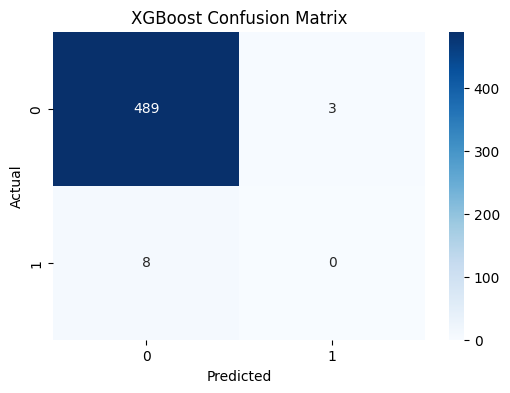

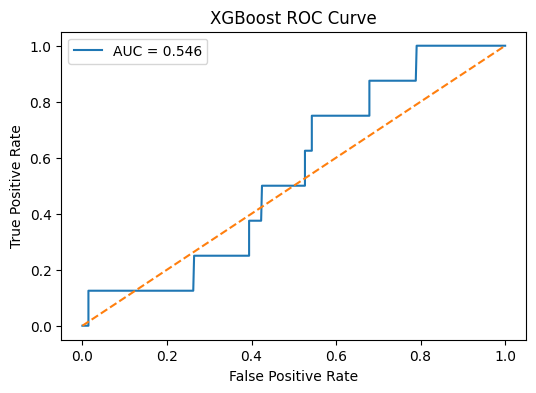

In [18]:
# 2. Gradient Boosting (using XGBoost)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
evaluate_model(xgb, X_test, y_test, "XGBoost")

In [19]:
# 3. Neural Network (Keras)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=128,
                    validation_split=0.2, callbacks=[early_stop], verbose=2)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
13/13 - 4s - 337ms/step - accuracy: 0.7136 - loss: 0.6104 - val_accuracy: 0.9850 - val_loss: 0.4398
Epoch 2/50
13/13 - 0s - 37ms/step - accuracy: 0.9669 - loss: 0.3894 - val_accuracy: 0.9850 - val_loss: 0.2836
Epoch 3/50
13/13 - 0s - 27ms/step - accuracy: 0.9850 - loss: 0.2480 - val_accuracy: 0.9850 - val_loss: 0.1803
Epoch 4/50
13/13 - 0s - 29ms/step - accuracy: 0.9850 - loss: 0.1666 - val_accuracy: 0.9850 - val_loss: 0.1199
Epoch 5/50
13/13 - 1s - 45ms/step - accuracy: 0.9850 - loss: 0.1182 - val_accuracy: 0.9850 - val_loss: 0.0934
Epoch 6/50
13/13 - 0s - 23ms/step - accuracy: 0.9850 - loss: 0.0981 - val_accuracy: 0.9850 - val_loss: 0.0844
Epoch 7/50
13/13 - 0s - 24ms/step - accuracy: 0.9850 - loss: 0.0913 - val_accuracy: 0.9850 - val_loss: 0.0823
Epoch 8/50
13/13 - 0s - 30ms/step - accuracy: 0.9850 - loss: 0.0858 - val_accuracy: 0.9850 - val_loss: 0.0823
Epoch 9/50
13/13 - 0s - 25ms/step - accuracy: 0.9850 - loss: 0.0812 - val_accuracy: 0.9850 - val_loss: 0.0825
Epoch 10/

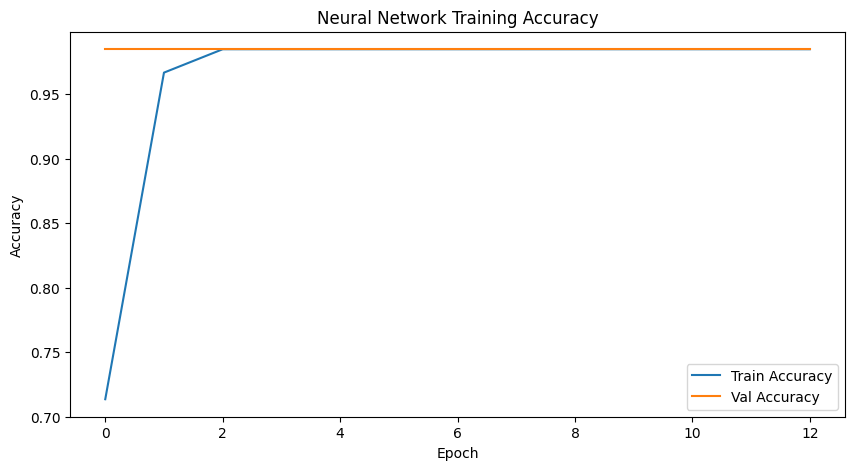

In [20]:
# Plot training history
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Neural Network Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Evaluate on test set
y_pred_nn = (model.predict(X_test_scaled) > 0.5).astype("int32")
y_proba_nn = model.predict(X_test_scaled).ravel()

print("----- Neural Network Classification Report -----")
print(classification_report(y_test, y_pred_nn))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
----- Neural Network Classification Report -----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       492
           1       0.00      0.00      0.00         8

    accuracy                           0.98       500
   macro avg       0.49      0.50      0.50       500
weighted avg       0.97      0.98      0.98       500



C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.

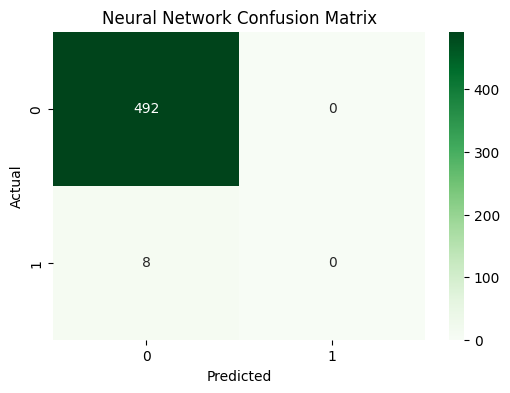

In [22]:
# Confusion matrix for NN
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

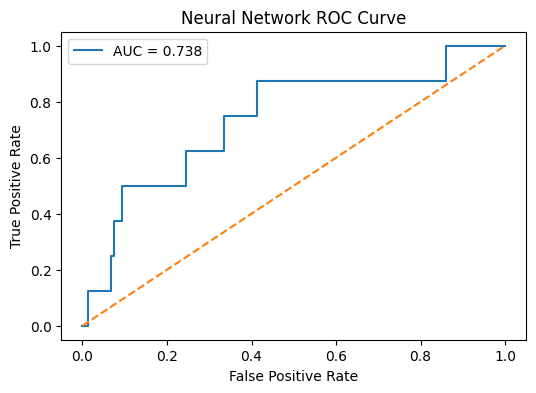

In [23]:
# ROC Curve and AUC for NN
fpr, tpr, _ = roc_curve(y_test, y_proba_nn)
auc = roc_auc_score(y_test, y_proba_nn)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('Neural Network ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

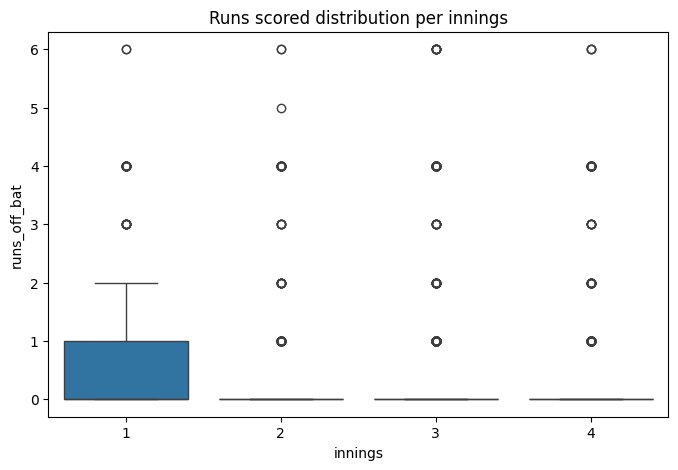

In [24]:
# 1. Runs scored per innings (boxplot)
plt.figure(figsize=(8,5))
sns.boxplot(x='innings', y='runs_off_bat', data=df)
plt.title('Runs scored distribution per innings')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11740\2578327461.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wickets_by_bowler.values, y=wickets_by_bowler.index, palette='viridis')


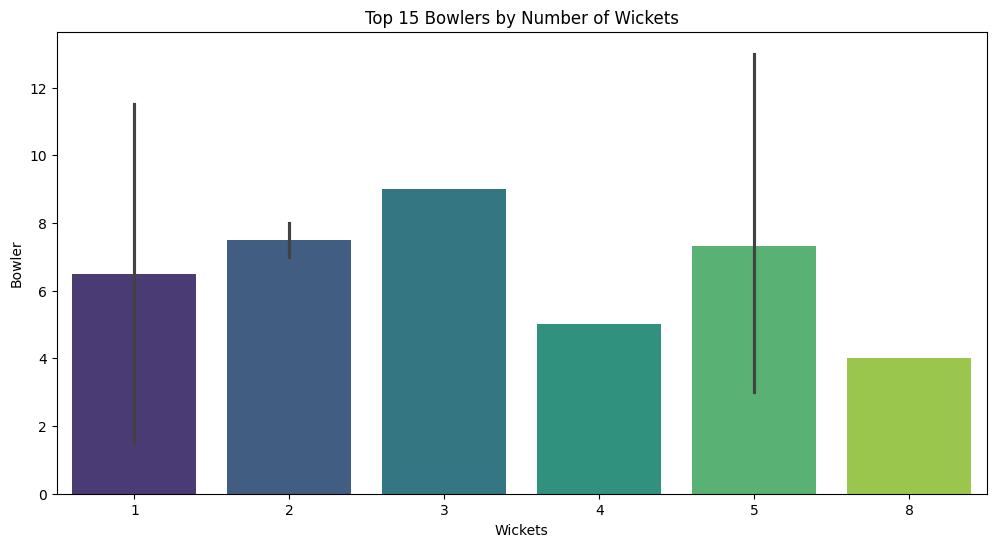

In [25]:
# 2. Total wickets per bowler (barplot)
plt.figure(figsize=(12,6))
wickets_by_bowler = df[df['wicket'] == 1]['bowler'].value_counts().head(15)
sns.barplot(x=wickets_by_bowler.values, y=wickets_by_bowler.index, palette='viridis')
plt.title('Top 15 Bowlers by Number of Wickets')
plt.xlabel('Wickets')
plt.ylabel('Bowler')
plt.show()

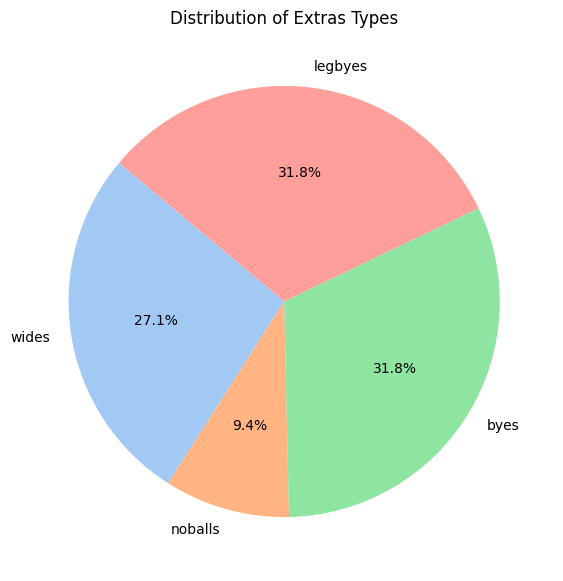

In [26]:
# 3. Extras breakdown (pie chart)
extras_sum = df[['wides','noballs','byes','legbyes']].sum()
plt.figure(figsize=(7,7))
plt.pie(extras_sum, labels=extras_sum.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Extras Types')
plt.show()

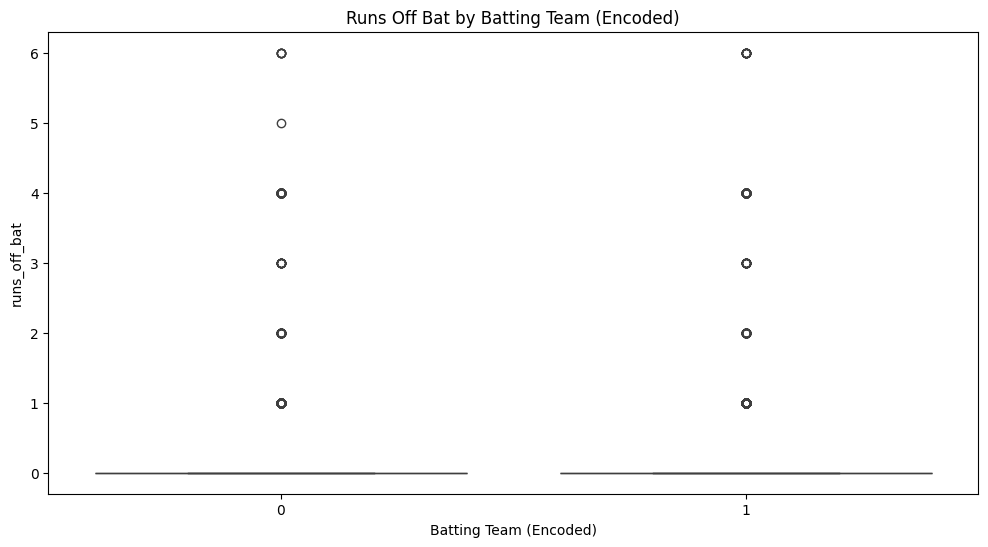

In [27]:
# 4. Runs off bat by batting team (boxplot)
plt.figure(figsize=(12,6))
sns.boxplot(x='batting_team', y='runs_off_bat', data=df)
plt.title('Runs Off Bat by Batting Team (Encoded)')
plt.xlabel('Batting Team (Encoded)')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11740\2940361281.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balls_by_bowler.values, y=balls_by_bowler.index, palette='magma')


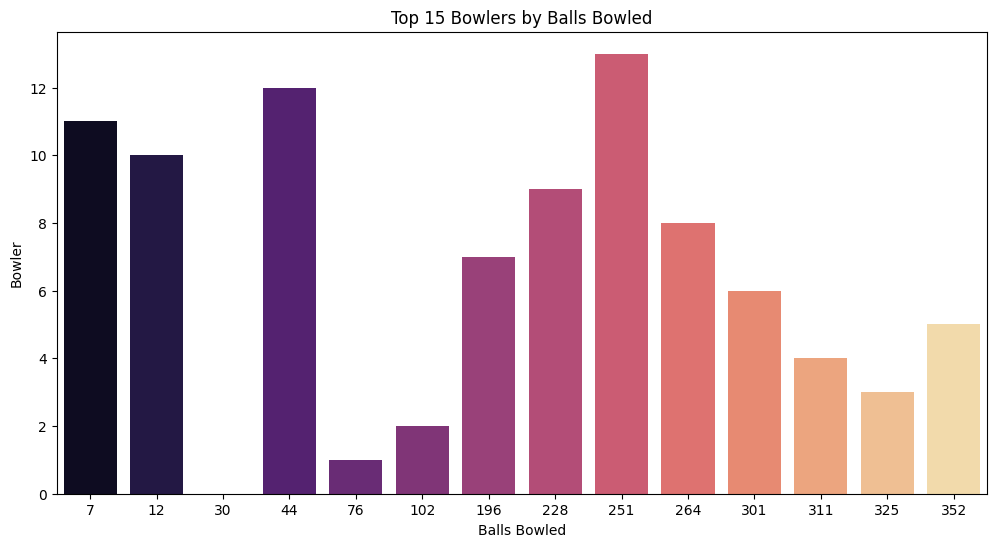

In [28]:
# 5. Balls bowled per bowler (bar plot)
plt.figure(figsize=(12,6))
balls_by_bowler = df['bowler'].value_counts().head(15)
sns.barplot(x=balls_by_bowler.values, y=balls_by_bowler.index, palette='magma')
plt.title('Top 15 Bowlers by Balls Bowled')
plt.xlabel('Balls Bowled')
plt.ylabel('Bowler')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11740\4174518536.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wicket_types.index, y=wicket_types.values, palette='coolwarm')


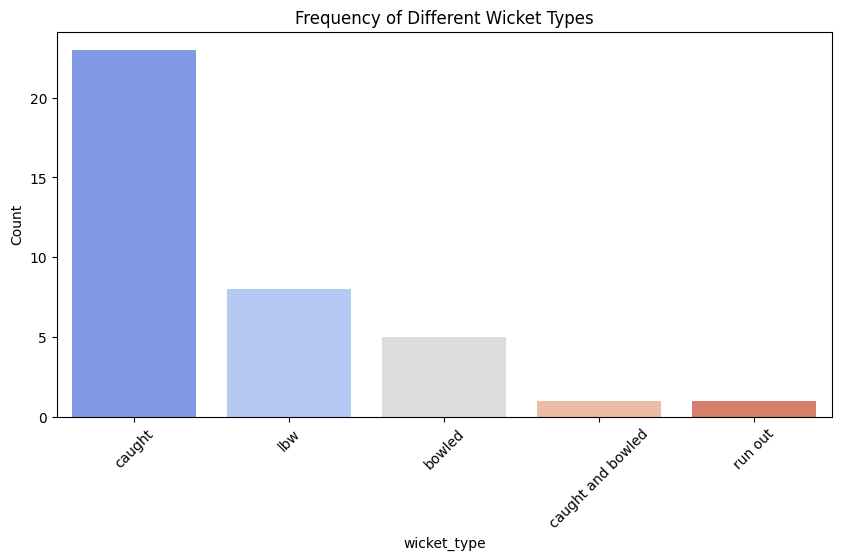

In [29]:
# 6. Wicket types frequency (bar plot)
plt.figure(figsize=(10,5))
wicket_types = df['wicket_type'].value_counts().dropna()
sns.barplot(x=wicket_types.index, y=wicket_types.values, palette='coolwarm')
plt.title('Frequency of Different Wicket Types')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

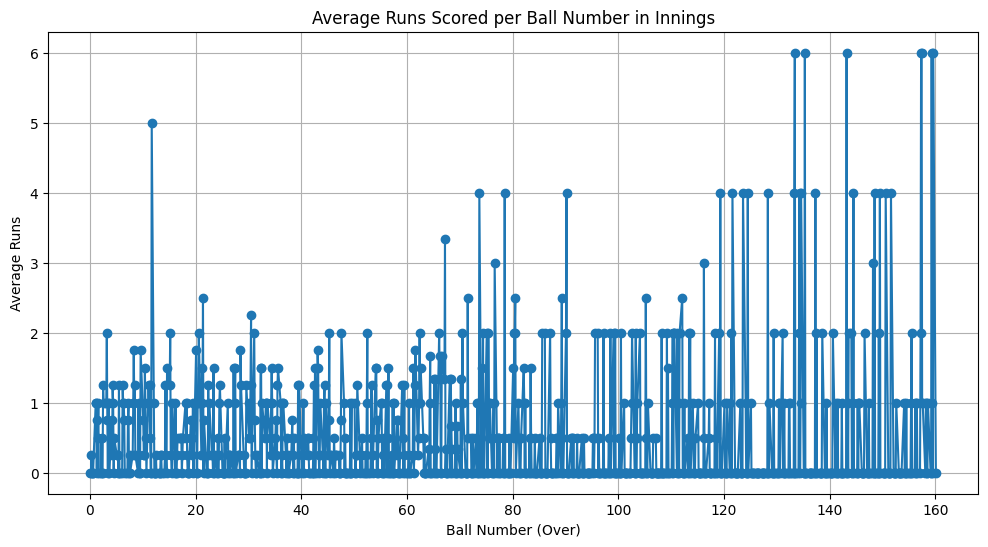

In [30]:
# 7. Runs over time (by ball number in innings) line plot
plt.figure(figsize=(12,6))
runs_per_ball = df.groupby('ball_over')['runs_off_bat'].mean()
plt.plot(runs_per_ball.index, runs_per_ball.values, marker='o')
plt.title('Average Runs Scored per Ball Number in Innings')
plt.xlabel('Ball Number (Over)')
plt.ylabel('Average Runs')
plt.grid(True)
plt.show()

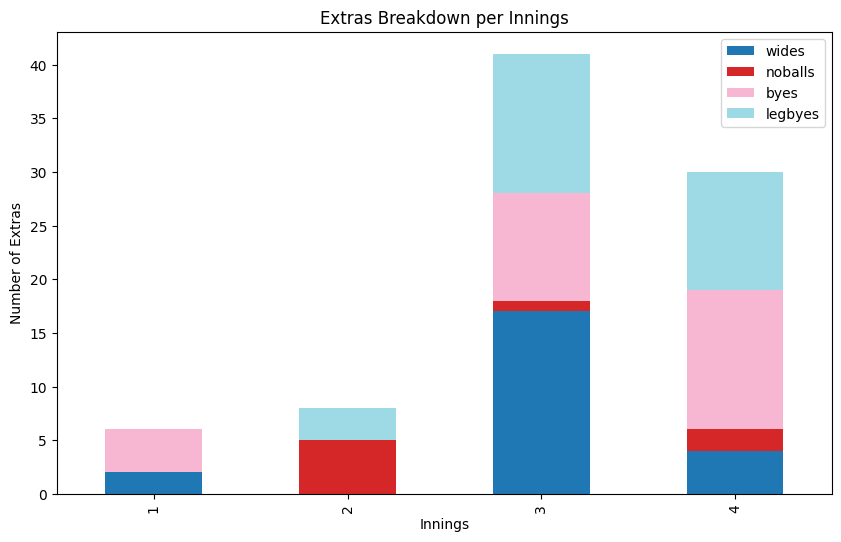

In [31]:
# 8. Extras per innings (stacked bar chart)
extras_innings = df.groupby('innings')[['wides','noballs','byes','legbyes']].sum()
extras_innings.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('Extras Breakdown per Innings')
plt.ylabel('Number of Extras')
plt.xlabel('Innings')
plt.show()

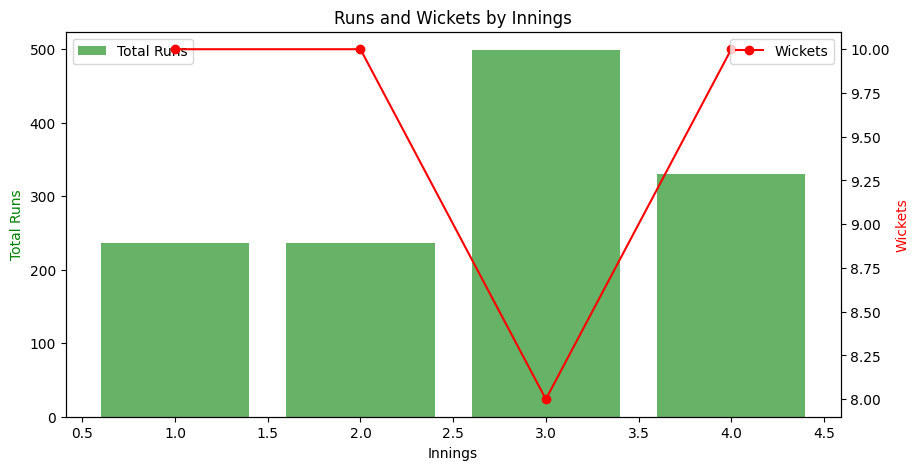

In [32]:
# 9. Runs scored vs wickets by innings (dual axis plot)
runs_innings = df.groupby('innings')['runs_off_bat'].sum()
wickets_innings = df[df['wicket'] == 1].groupby('innings')['wicket'].count()

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()
ax1.bar(runs_innings.index, runs_innings.values, color='green', alpha=0.6, label='Total Runs')
ax2.plot(wickets_innings.index, wickets_innings.values, color='red', marker='o', label='Wickets')

ax1.set_xlabel('Innings')
ax1.set_ylabel('Total Runs', color='green')
ax2.set_ylabel('Wickets', color='red')
plt.title('Runs and Wickets by Innings')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_11740\3893228866.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=balls_per_season.index, y=balls_per_season.values, palette='Blues_d')


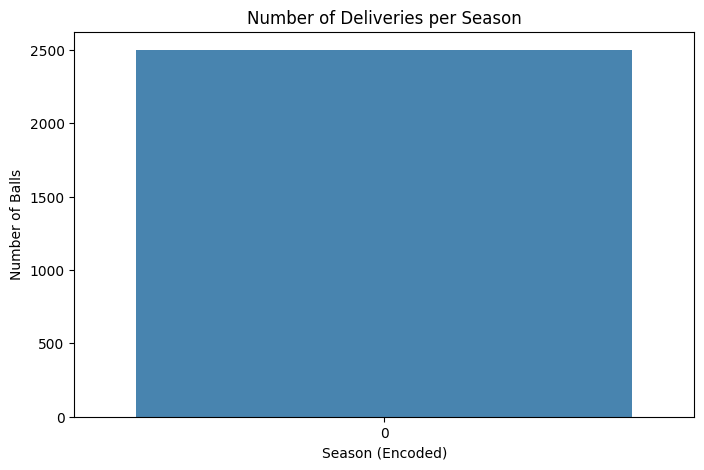

In [33]:
# 10. Count of deliveries by season (bar chart)
plt.figure(figsize=(8,5))
balls_per_season = df['season'].value_counts().sort_index()
sns.barplot(x=balls_per_season.index, y=balls_per_season.values, palette='Blues_d')
plt.title('Number of Deliveries per Season')
plt.xlabel('Season (Encoded)')
plt.ylabel('Number of Balls')
plt.show()

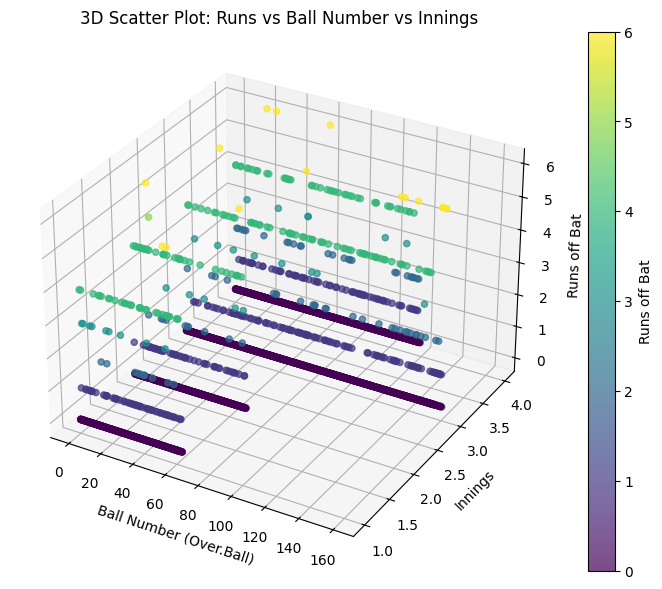

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Convert 'ball' column string to float (if not already)
df['ball'] = df['ball'].astype(float)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with:
# X = ball number (e.g., 0.1, 0.2...)
# Y = innings
# Z = runs_off_bat
sc = ax.scatter(df['ball'], df['innings'], df['runs_off_bat'], c=df['runs_off_bat'], cmap='viridis', alpha=0.7)

ax.set_xlabel('Ball Number (Over.Ball)')
ax.set_ylabel('Innings')
ax.set_zlabel('Runs off Bat')

plt.title('3D Scatter Plot: Runs vs Ball Number vs Innings')
plt.colorbar(sc, label='Runs off Bat')

plt.show()
